In [2]:
import json
import torch

from utils import init_sequential

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import quad

import gc

torch.set_grad_enabled(False)

ROOT = Path('model')
ARCH = Path('arch')

FIGURES = Path('figures')
FIGURES_PRED = FIGURES / 'pred/'
FIGURES_EIGV = FIGURES / 'eigv/'
FIGURES_BASIS = FIGURES / 'basis/'
FIGURES_KERNEL = FIGURES / 'kernel/'
FIGURES_ERROR = FIGURES / 'error/'

FIGURES_PRED.mkdir(exist_ok=True, parents=True)
FIGURES_EIGV.mkdir(exist_ok=True, parents=True)
FIGURES_BASIS.mkdir(exist_ok=True, parents=True)
FIGURES_KERNEL.mkdir(exist_ok=True, parents=True)
FIGURES_ERROR.mkdir(exist_ok=True, parents=True)

name = 'S1_enc100_raw'
epoch = 2_500

with open(ARCH / f'{name}.json', 'r') as f:
    params = json.load(f)

PATH = ROOT / params['name']

savefig = True
MODEL_PREFIX = r'$S^1_{\theta}$'

FIGURES_PREFIX = f'{params["name"]}_epoch{epoch}'
plt.rc('font', size=14)
plt.rc('lines', linewidth=2)

# FIGURES_PREFIX = f'{params["name"]}_epoch{epoch}_slide'
# plt.rc('font', size=16)
# plt.rc('lines', linewidth=4)

In [3]:
A = init_sequential(
    params['layers-apprx'],
    params['apprx-finish_with_activation'])

T = init_sequential(
    params['layers-trunk'],
    params['trunk-finish_with_activation'])

In [4]:
data = torch.load(ROOT / params['name'] / f'{epoch}.model')

A.load_state_dict(data['A'][0])
T.load_state_dict(data['T'][0])

<All keys matched successfully>

In [5]:
def model(xb, p):
    ''' (b, encdim), (M) -> (B, M, latdim) '''
    a = A(xb)
    b = T(p.unsqueeze(dim=1))
    return a @ b.T

In [6]:
match params['quad-name']:
    case 'gaussian':
        int_p, int_w = quad.gaussian_quadrature(0, 1, params['quad-size'])
    case _:
        int_p, int_w = quad.trapezoidal_rule(0, 1, params['quad-size'])

/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


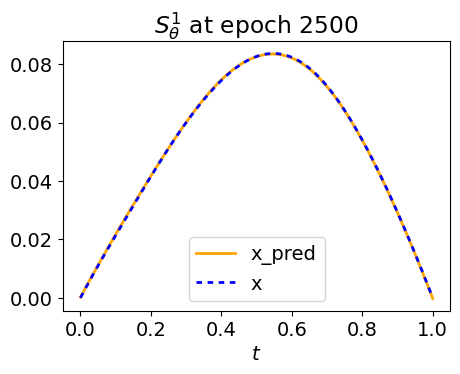

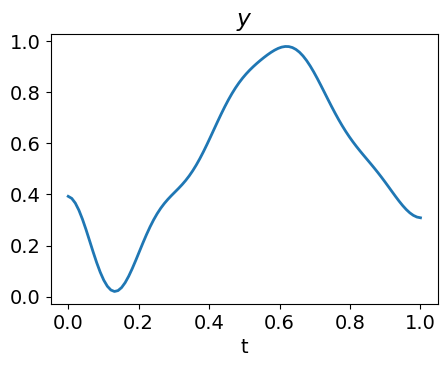

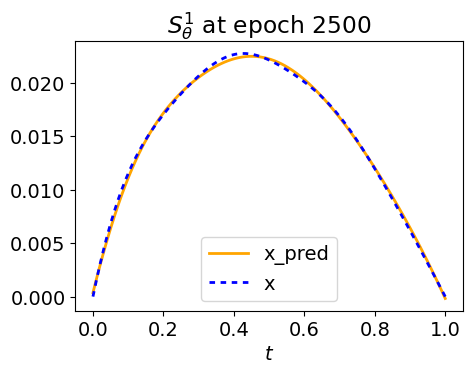

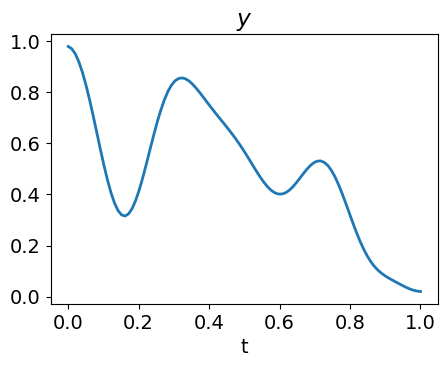

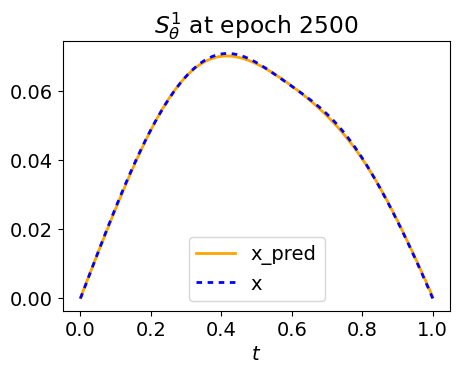

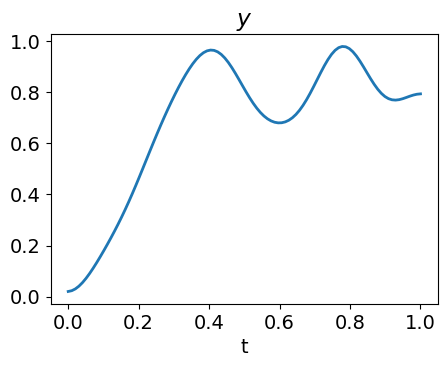

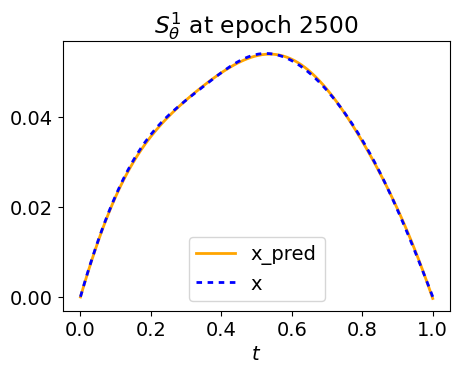

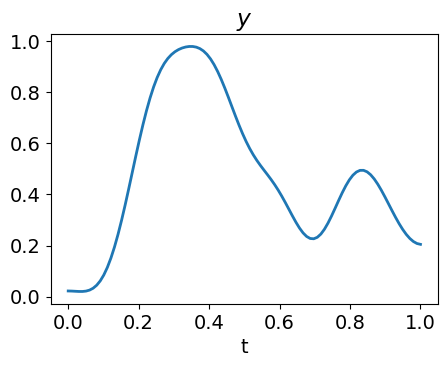

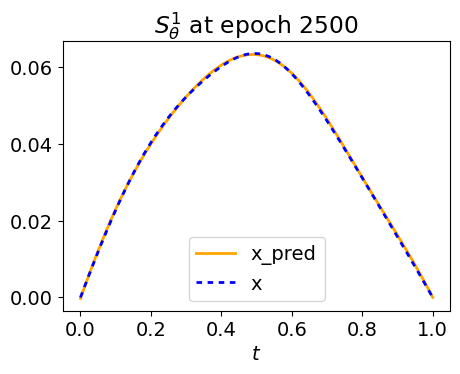

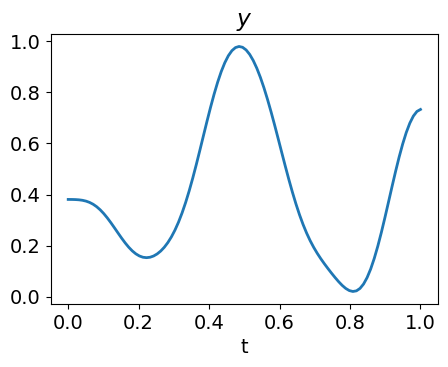

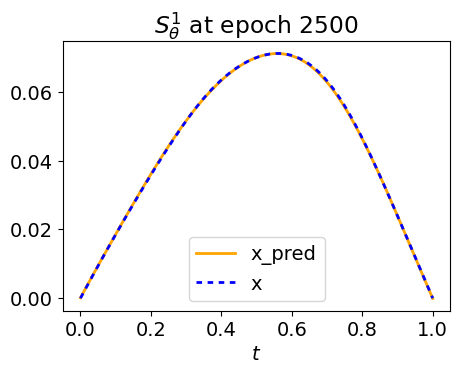

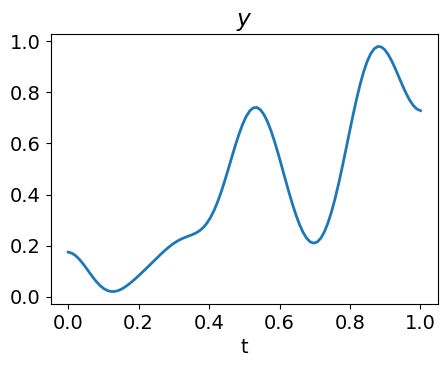

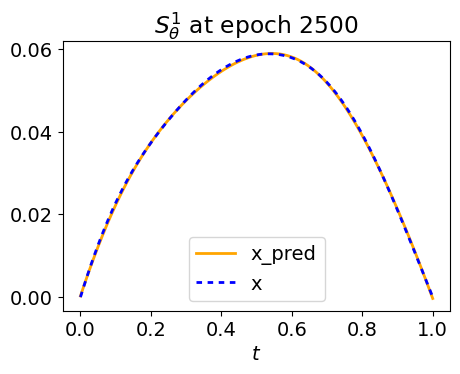

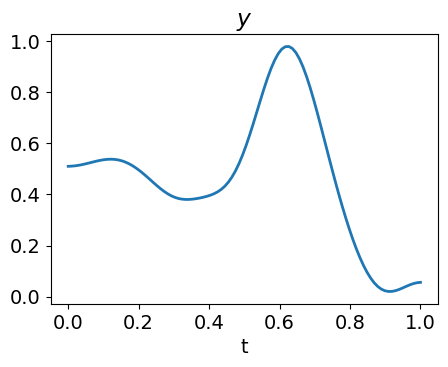

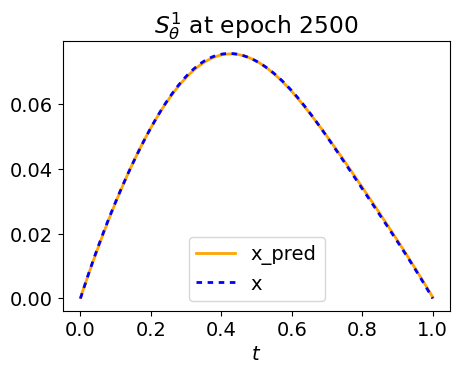

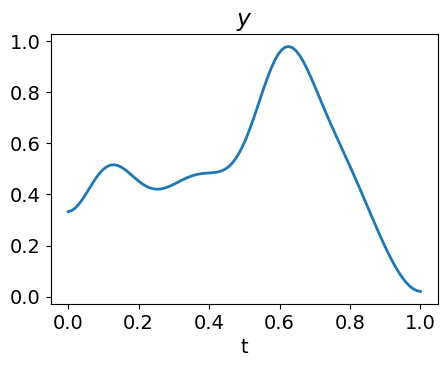

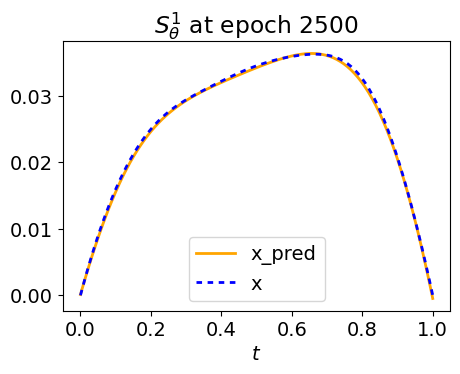

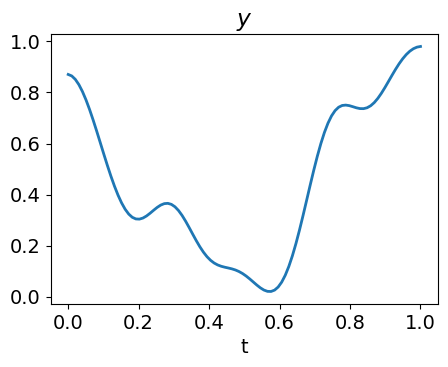

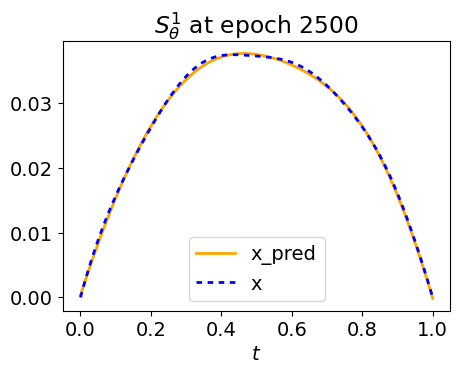

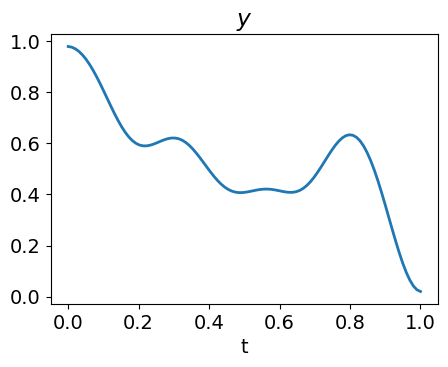

In [7]:
x_ds, y_ds = torch.load(PATH / 'valid.ds')
size = len(x_ds[0])
step = size // 10

for i, idx in enumerate(range(0, size, step)):
    Y = torch.load(f'dataset/ds20k/valid/{i}_Y.pt')
    X = torch.load(f'dataset/ds20k/valid/{i}_X.pt')

    ip = torch.linspace(0, 1, len(X))

    x_pred = model(x_ds[idx].unsqueeze(dim=0), int_p).squeeze()
    x = torch.tensor(np.interp(int_p, ip, X)).float()
    y = torch.tensor(np.interp(int_p, ip, Y)).float()

    plt.figure(figsize=(5, 3.5))
    plt.plot(int_p, x_pred, c='orange', label='x_pred')
    plt.plot(int_p, y_ds[idx], 'b--', dashes=[2], label='x')
    plt.xlabel(r'$t$')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_Fig{i}.png', bbox_inches = 'tight')
    plt.title(MODEL_PREFIX + f' at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_Fig{i}_with_title.png', bbox_inches = 'tight')
    plt.show()

    plt.figure(figsize=(5, 3.5))
    plt.plot(int_p, y)
    plt.xlabel('t')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_y_Fig{i}.png', bbox_inches = 'tight')

    plt.title(r'$y$')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_y_Fig{i}_with_title.png', bbox_inches = 'tight')

    plt.show()

    gc.collect(2)

 Basis

In [7]:
def compute_EIGV(BASIS, t):
    EIGV = []
    for i, b in enumerate(BASIS):
        benc = np.interp(np.linspace(0, 1, params['layers-apprx'][0]), t, b)
        num = (b * model(torch.tensor(benc).float(), int_p)) @ int_w
        den = (b * b) @ int_w
        EIGV.append(num / den)
    return torch.tensor(EIGV)

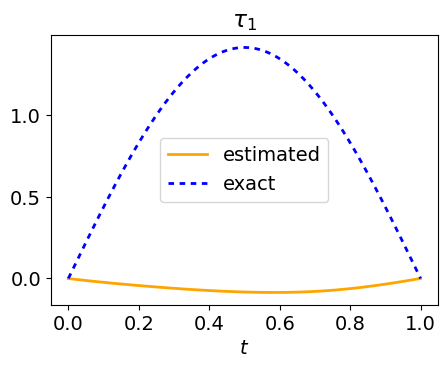

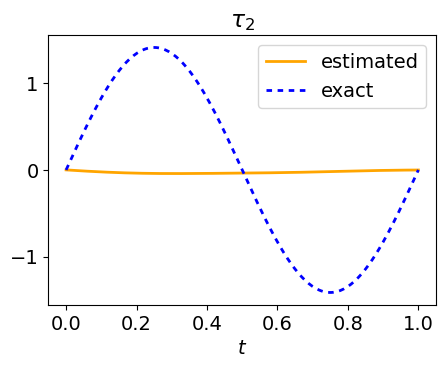

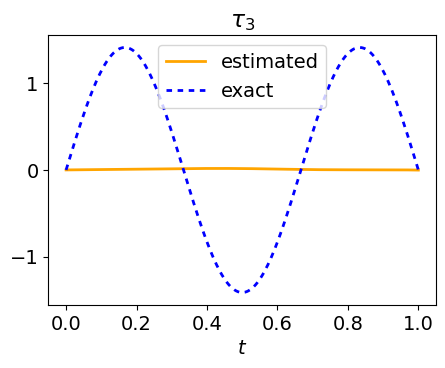

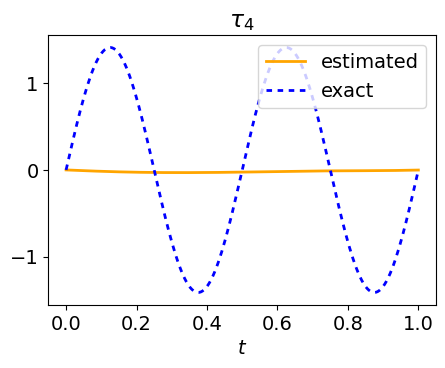

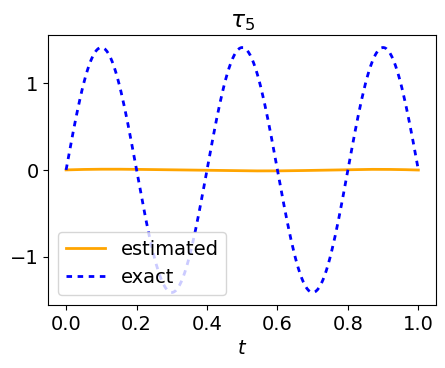

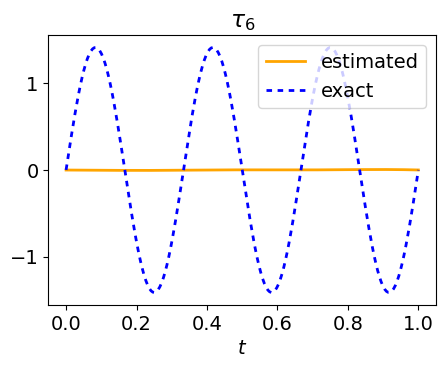

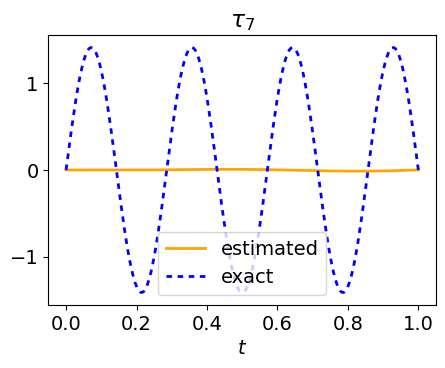

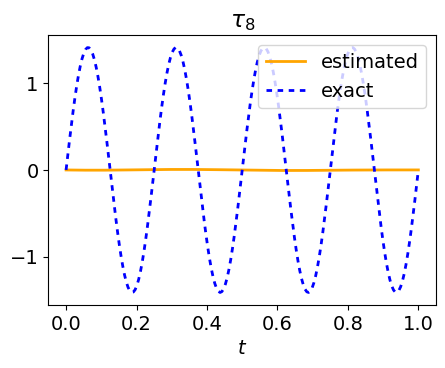

In [8]:
'''  
First: show learned eigenbasis
Second: apply gram schmidt and show learned orthonormalize eigenbasis
'''
N = 200
t = torch.linspace(0, 1, N)

int_p, int_w = quad.trapezoidal_rule(0, 1, N)

Real_basis = []
for k in range(1, 9):
    Real_basis.append(torch.sin(torch.pi*k*t))

#  Gram-Schmidt
V = Real_basis
n = len(V)
Q = [None for _ in range(n)]
R = [[0.0 for __ in range(n)] for _ in range(n)]

_, int_w_aux = quad.trapezoidal_rule(0, 1, N)
for i in range(n):
    R[i][i] = torch.sqrt(V[i] * V[i] @ int_w_aux)
    Q[i] = V[i] / R[i][i]
    for j in range(i+1, n):
        R[i][j] = V[j] * Q[i] @ int_w_aux
        if abs(R[i][j]) >= 1e-1:
            V[j] = V[j] - (Q[i] * R[i][j])
# End Gram-Schmidt

Real_basis = np.array(Q)
Real_eigv = [
    1/(torch.pi*k)**2
    for k in range(1, 9)
]

BASIS = T(t.unsqueeze(dim=1)).T.detach()
EIGV = compute_EIGV(BASIS, t)

idx = torch.argsort(EIGV, descending=True)

EIGV = EIGV[idx]
BASIS = BASIS[idx]

for i, b in enumerate(BASIS):
    plt.figure(figsize=(5, 3.5))
    plt.plot(t, b, c='orange', label='estimated')
    plt.plot(t, Real_basis[i], 'b--', dashes=[2], label='exact')
    plt.xlabel(r'$t$')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_Fig{i}.png', bbox_inches='tight')
        plt.title(r'$\tau_{}$'.format(i+1))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

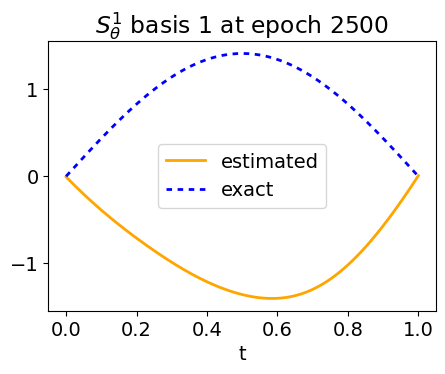

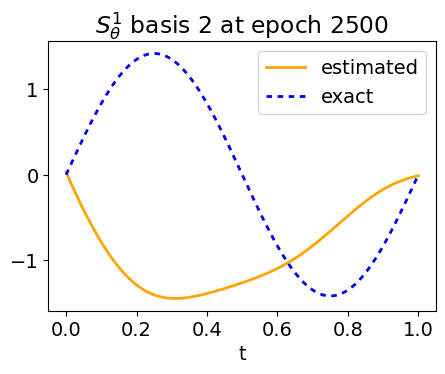

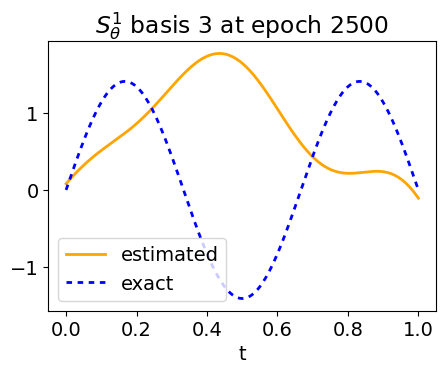

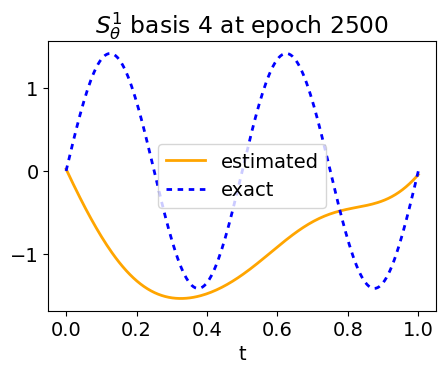

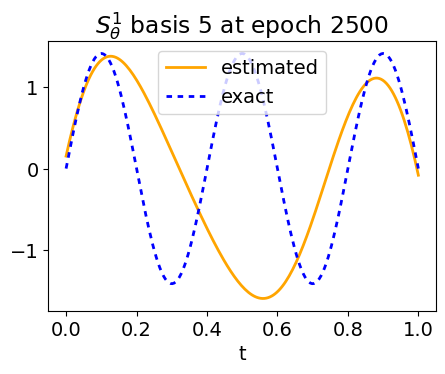

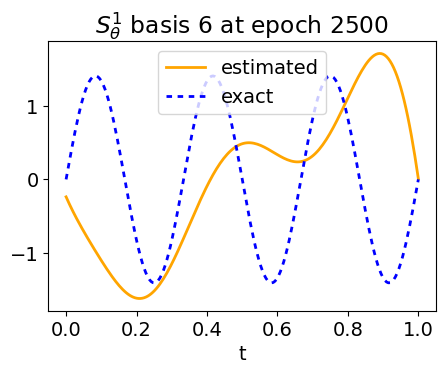

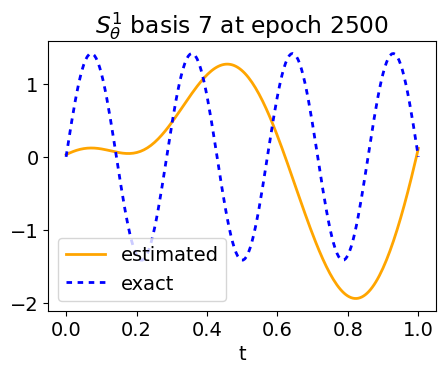

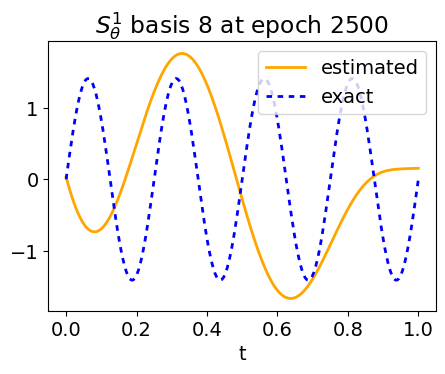

In [9]:
#Gram-Schmidt
V = BASIS
n = len(V)
Q = [None for _ in range(n)]
R = [[0.0 for __ in range(n)] for _ in range(n)]

_, int_w_aux = quad.trapezoidal_rule(0, 1, N)
for i in range(n):
    R[i][i] = torch.sqrt(V[i] * V[i] @ int_w_aux)
    Q[i] = V[i] / R[i][i]
    for j in range(i+1, n):
        R[i][j] = V[j] * Q[i] @ int_w_aux
        if abs(R[i][j]) >= 1e-1:
            V[j] = V[j] - (Q[i] * R[i][j])
#End Gram-Schmidt

O_BASIS = torch.stack(Q)
for i, b in enumerate(O_BASIS):
    plt.figure(figsize=(5, 3.5))
    plt.plot(t, b, c='orange', label='estimated')
    plt.plot(t, Real_basis[i], 'b--', dashes=[2], label='exact')

    plt.xlabel('t')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_orth_Fig{i}.png', bbox_inches='tight')
    plt.title(r'$S^1_{\theta}$' + f' basis {i+1} at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_orth_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

O_EIGV = compute_EIGV(O_BASIS, t)

idx = torch.argsort(EIGV, descending=True)

O_BASIS = O_BASIS[idx]
O_EIGV = O_EIGV[idx]

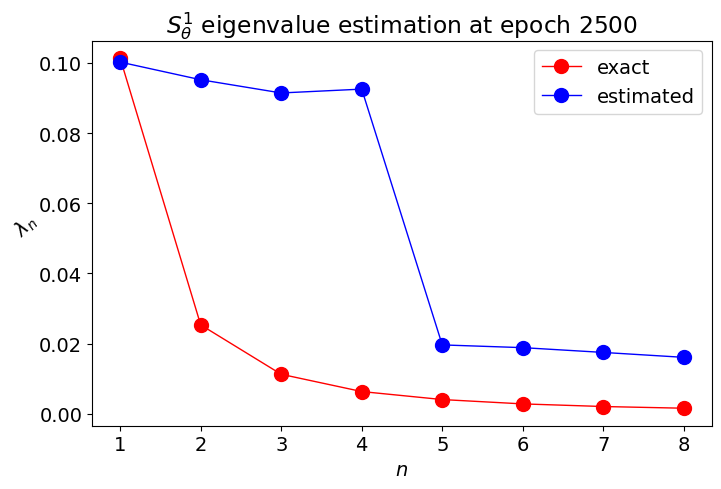

In [10]:
gc.collect(2)

plt.figure(figsize=(8, 5))
plt.plot(list(range(1, 9)), [1/(torch.pi*k)**2 for k in range(1, len(O_BASIS)+1)], 
         'or-', label='exact',
        markersize=10, linewidth=1)
plt.plot(list(range(1, 9)), O_EIGV, 'ob-', label='estimated',
        markersize=10, linewidth=1)
plt.legend()
plt.ylabel(r'$\lambda_n$', rotation=45)
plt.xlabel(r'$n$')
if savefig:
    plt.savefig(FIGURES_EIGV / f'{FIGURES_PREFIX}_orth.png', bbox_inches='tight')
plt.title(MODEL_PREFIX + f' eigenvalue estimation at epoch {epoch}')
if savefig:
    plt.savefig(FIGURES_EIGV / f'{FIGURES_PREFIX}_orth_with_title.png', bbox_inches='tight')
plt.show()

# Basis2Kernel

In [11]:
def compute_ticks(a):
    return [a.min(), a.mean(), a.max()]

In [12]:
def compute_kernel(BASIS, EIGV):
    s = torch.zeros(8, N, N)
    for i in range(len(BASIS)):
        s[i] = torch.outer(BASIS[i], BASIS[i]) * EIGV[i]
    
    return torch.sum(s, axis=0)

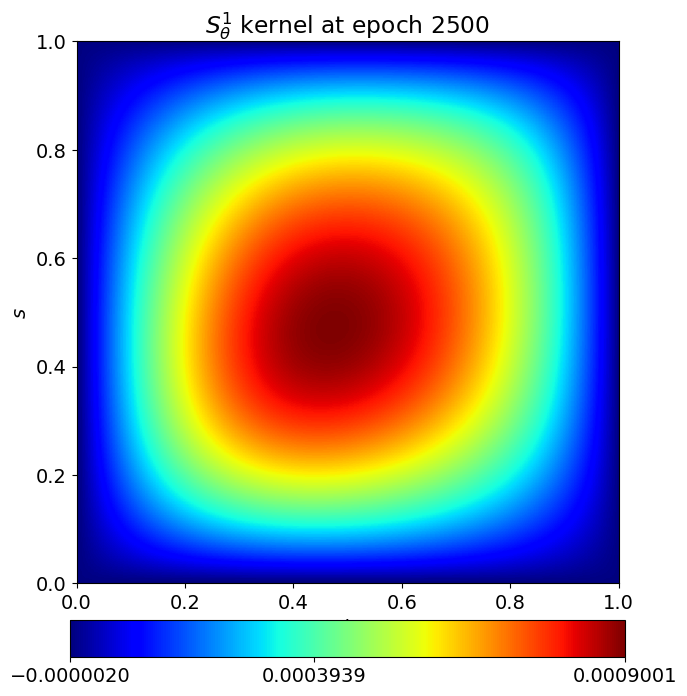

In [13]:
kernel = compute_kernel(BASIS, EIGV)
plt.figure(figsize=(8, 8))
plt.imshow(kernel.flip(1), cmap='jet', extent=[0, 1, 0, 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$s$')
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}.png', bbox_inches='tight')
plt.colorbar(location='bottom', aspect=15, fraction=0.06, pad=0.06, ticks=compute_ticks(kernel))
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}_with_cbar.png', bbox_inches='tight')
plt.title(r'$S^1_{\theta}$' + f' kernel at epoch {epoch}')
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}_with_cbar_with_title.png', bbox_inches='tight')
plt.show()

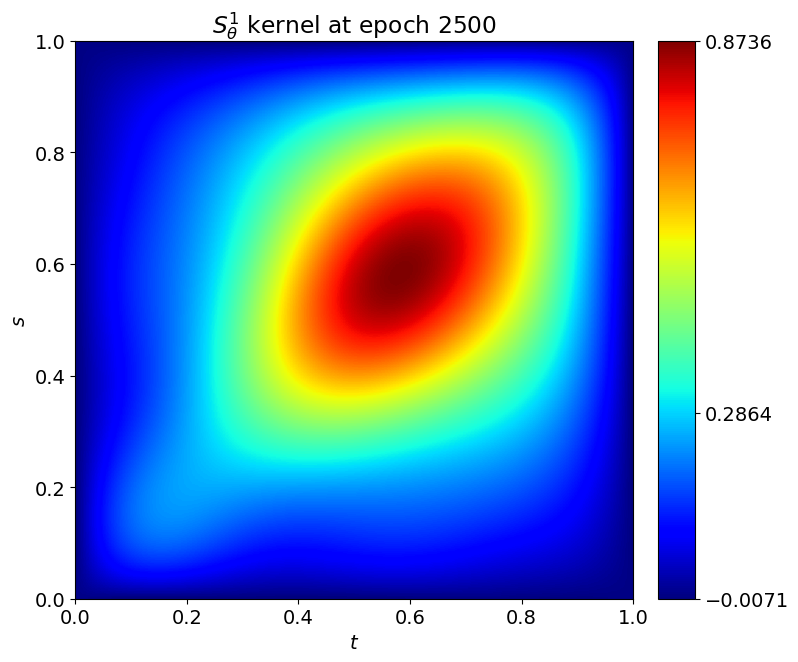

In [14]:
O_kernel = compute_kernel(O_BASIS, O_EIGV)
plt.figure(figsize=(8, 8))
plt.imshow(O_kernel.flip(1), cmap='jet', extent=[0, 1, 0, 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$s$')
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}_orth.png', bbox_inches='tight')
plt.colorbar(location='right', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(O_kernel))
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}_orth_with_cbar.png', bbox_inches='tight')
plt.title(r'$S^1_{\theta}$' + f' kernel at epoch {epoch}')
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}_orth_with_cbar_with_title.png', bbox_inches='tight')
plt.show()

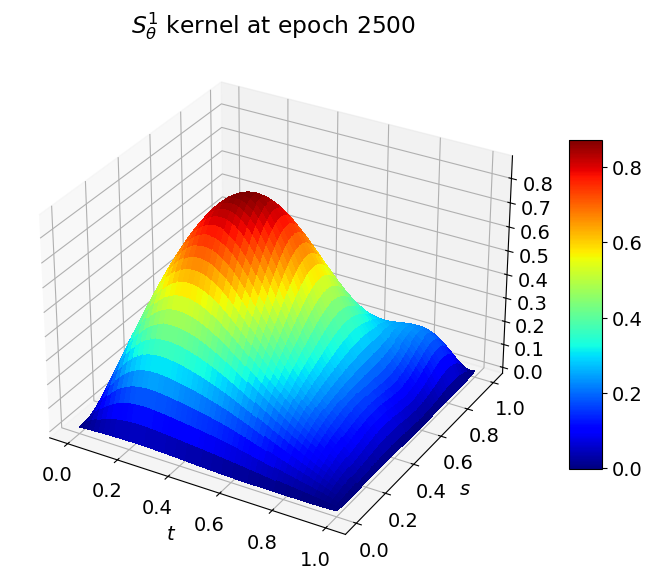

In [15]:
tt = torch.stack(torch.meshgrid(t, t, indexing='xy')).reshape(2, -1)

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "3d"})
fig.tight_layout()

surf = ax.plot_surface(tt[0].reshape(N, N), tt[1].reshape(N,N), O_kernel, cmap='jet',
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_title(MODEL_PREFIX + f' kernel at epoch {epoch}')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$s$')

if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}_3d.png', bbox_inches='tight')

plt.show()

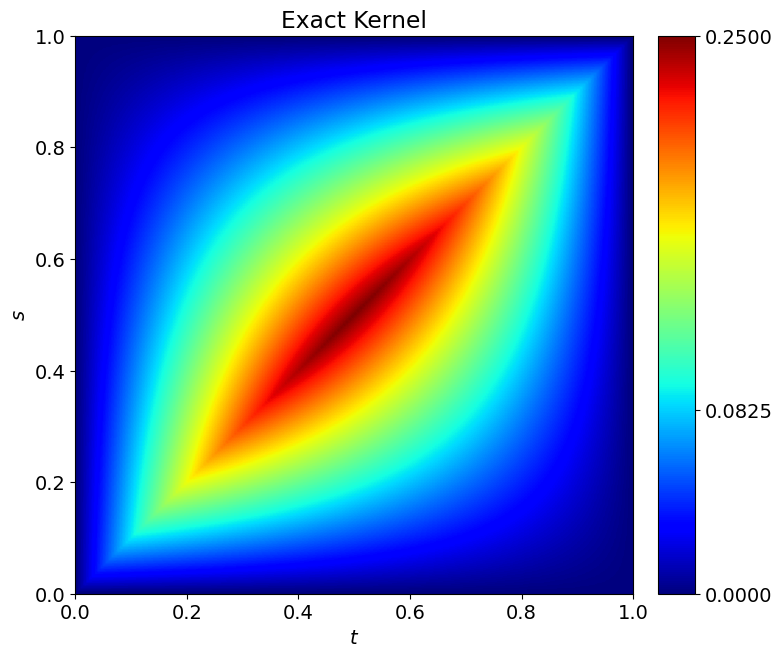

In [16]:
tt = torch.stack(torch.meshgrid(t, t, indexing='xy')).reshape(2, -1).T

Exact_kernel = torch.zeros(tt.shape[0])
cond = tt[:, 0] < tt[:, 1]
Exact_kernel[cond] = tt[cond, 0] * (1 - tt[cond, 1])
Exact_kernel[~cond] = tt[~cond, 1] * (1 - tt[~cond, 0])
Exact_kernel = Exact_kernel.reshape(N, N)

plt.figure(figsize=(8, 8))
plt.tight_layout()
plt.imshow(Exact_kernel.flip(1), cmap='jet', extent=[0, 1, 0, 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$s$')
if savefig:
    plt.savefig(FIGURES_KERNEL / 'exact.png', bbox_inches='tight')
plt.colorbar(location='right', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(Exact_kernel))
if savefig:
    plt.savefig(FIGURES_KERNEL / 'exact_with_cbar.png', bbox_inches='tight')
plt.title('Exact Kernel')
if savefig:
    plt.savefig(FIGURES_KERNEL / 'exact_with_cbar_with_title.png', bbox_inches='tight')
plt.show()

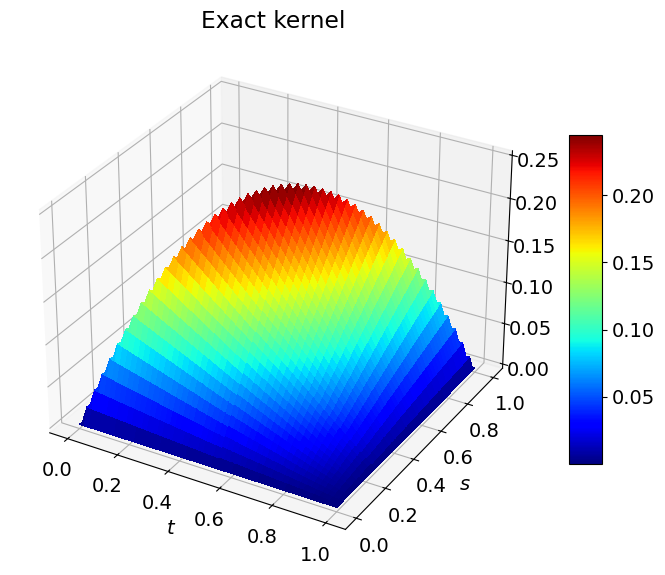

In [17]:
tt = torch.stack(torch.meshgrid(t, t, indexing='xy')).reshape(2, -1)

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "3d"})
fig.tight_layout()

surf = ax.plot_surface(tt[0].reshape(N, N), tt[1].reshape(N,N), Exact_kernel, cmap='jet',
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_title('Exact kernel')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$s$')

if savefig:
    plt.savefig(FIGURES_KERNEL / f'exact_3d.png', bbox_inches='tight')

plt.show()

In [18]:
Trunc_kernel = torch.zeros(N, N)

for i in range(8):
    Trunc_kernel += torch.outer(torch.tensor(Real_basis[i]), torch.tensor(Real_basis[i])) * Real_eigv[i]

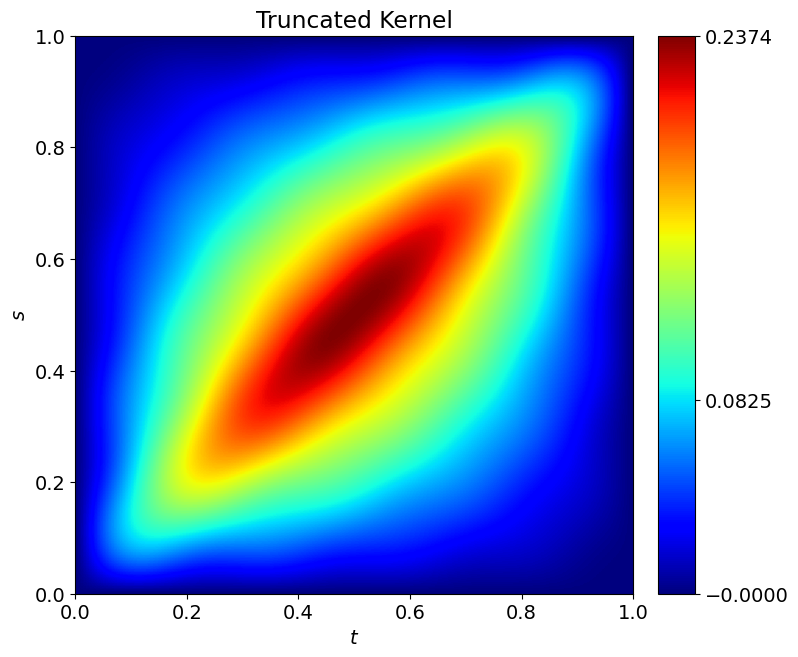

In [19]:
plt.figure(figsize=(8, 8))
plt.tight_layout()
plt.imshow(Trunc_kernel.flip(1), cmap='jet', extent=[0, 1, 0, 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$s$')
if savefig:
    plt.savefig(FIGURES_KERNEL / 'trunc.png', bbox_inches='tight')
plt.colorbar(location='right', aspect=15, fraction=0.06, pad=0.04, ticks=compute_ticks(Trunc_kernel))
if savefig:
    plt.savefig(FIGURES_KERNEL / 'trunc_with_cbar.png', bbox_inches='tight')
plt.title('Truncated Kernel')
if savefig:
    plt.savefig(FIGURES_KERNEL / 'trunc_with_cbar_with_title.png', bbox_inches='tight')

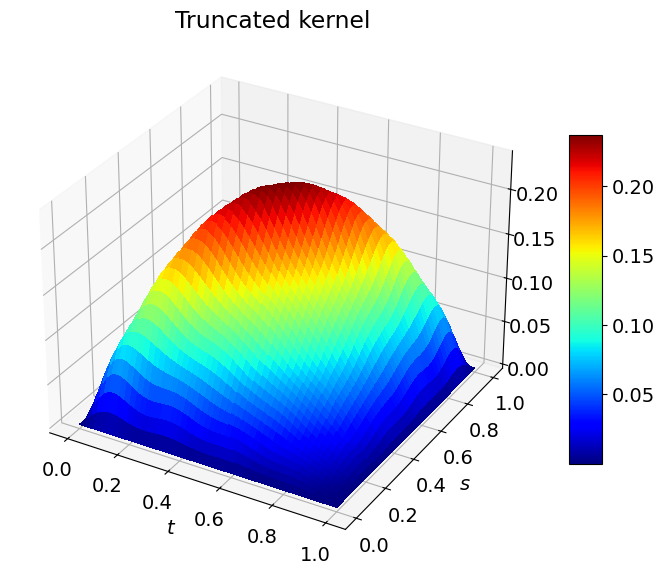

In [20]:
tt = torch.stack(torch.meshgrid(t, t, indexing='xy')).reshape(2, -1)

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "3d"})
fig.tight_layout()

surf = ax.plot_surface(tt[0].reshape(N, N), tt[1].reshape(N,N), Trunc_kernel, cmap='jet',
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_title('Truncated kernel')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$s$')

if savefig:
    plt.savefig(FIGURES_KERNEL / f'trunc_3d_epoch.png', bbox_inches='tight')

plt.show()

In [21]:
gc.collect(2)

48082

In [22]:
def read_error_log(logfile, rf, maxepoch=float('infinity')):
    error = []
    with open(logfile, 'r') as f:
        for line in f:
            ep, err = line.strip().split(',')
            ep = int(ep)
            err = float(err)

            if ep > maxepoch:
                break
            
            if ep % rf == 0:
                error.append(err)
    return error

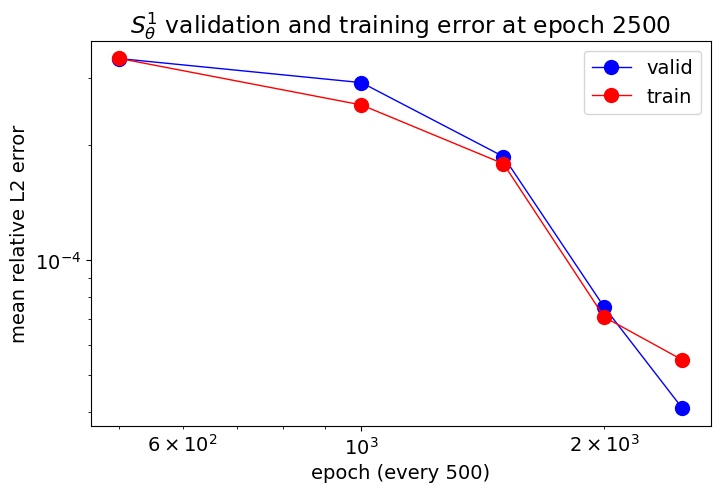

<Figure size 800x500 with 0 Axes>

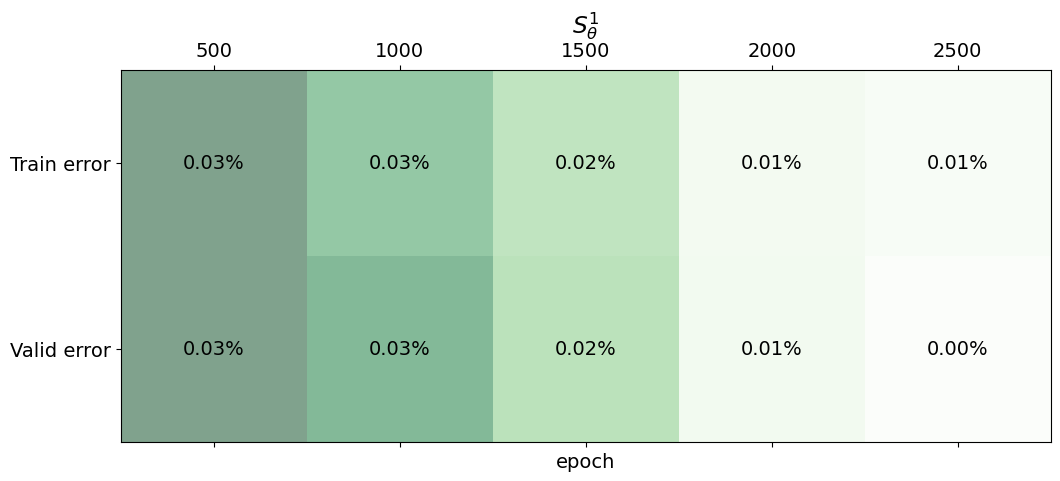

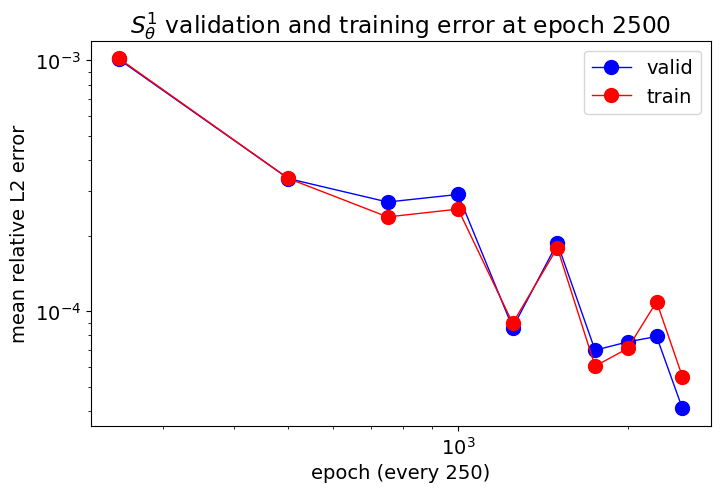

<Figure size 800x500 with 0 Axes>

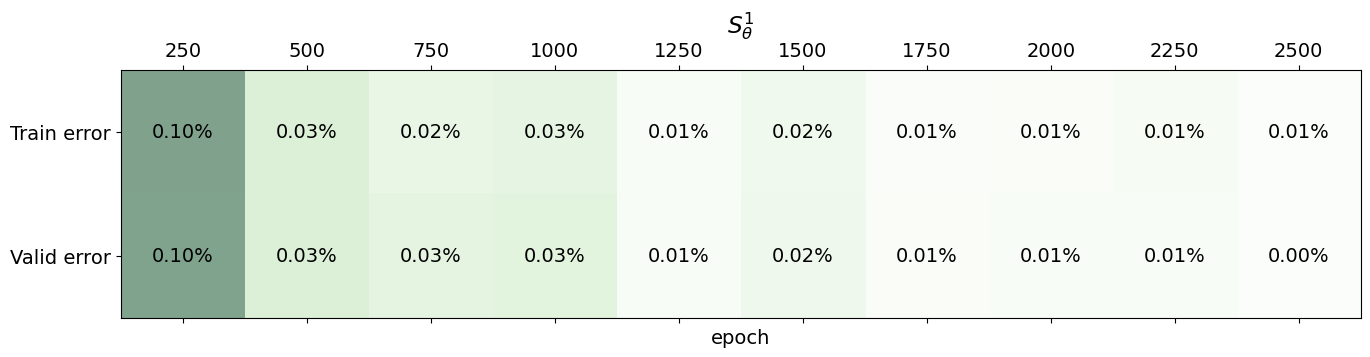

In [23]:
for rf_ in [5, 10]:
    rf = epoch // rf_
    timeline = [i for i in range(rf, epoch+rf, rf)]
    
    valid_error = read_error_log(PATH / 'valid.error', rf, maxepoch=epoch)
    train_error = read_error_log(PATH / 'train.error', rf, maxepoch=epoch)

    ##  PLOT
    plt.figure(figsize=(8, 5))
    plt.loglog(timeline, valid_error, '-ob', label='valid', markersize=10, linewidth=1)
    plt.loglog(timeline, train_error, '-or', label='train', markersize=10, linewidth=1)
    plt.title(MODEL_PREFIX + f' validation and training error at epoch {epoch}')
    plt.xlabel(f'epoch (every {rf})')
    plt.ylabel('mean relative L2 error')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_rf{rf_}.png', bbox_inches='tight')
    plt.show()

    ##  TABLE
    data = np.array(list(zip(train_error, valid_error))).T

    plt.figure(figsize=(8, 5))
    plt.tight_layout()
    plt.matshow(100 * data, cmap='Greens', alpha=0.5)
    plt.xlabel('epoch')
    plt.xticks(np.array(range(len(timeline))), timeline)
    plt.yticks(list(range(2)), ['Train error', 'Valid error'])
    
    for (i, j), z in np.ndenumerate(data):
        plt.text(j, i, '{:0.2f}%'.format(100 * z), ha='center', va='center')

    if savefig:
        plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_table_rf{rf_}.png', bbox_inches='tight')
    
    plt.title(MODEL_PREFIX)
    if savefig:
        plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_table_rf{rf_}_with_title.png', bbox_inches='tight')
    
    plt.show()

In [24]:
rf = epoch // 20
epoch_timeline = [k for k in range(0, epoch, rf)]

values = torch.zeros(epoch // rf, len(t), 8)
for i, k in enumerate(epoch_timeline):
    data = torch.load(PATH / f'{k}.model')
    T.load_state_dict(data['T'][0])

    values[i] = T(t.unsqueeze(dim=1)).squeeze()

/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: 'model/S1_enc100_lat8/125.model'

In [ ]:
for i in range(8):
    ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
    plt.tight_layout()

    for j, k in enumerate(epoch_timeline):
        ax.plot(k, t, values[j, :, i], linewidth=5)
    
    ax.set_xlabel('epoch')
    ax.set_title(fr'$\tau_{i+1}$', fontsize=20)
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_evolution_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
for i in range(8):
    ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
    plt.tight_layout()

    for j, k in enumerate(epoch_timeline[1:], start=1):
        ax.plot(k, t, values[j, :, i], linewidth=5)
        
    ax.tick_params(labelsize=12)
    ax.set_xlabel('epoch')
    ax.set_title(fr'$\tau_{i+1}$', fontsize=20)
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_evolution_Fig{i}_without_first_with_title.png', bbox_inches='tight')
    plt.show()

In [ ]:
print(params["name"])